In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import (
    auprc,
    factor_enrichment_gsea,
    get_gprofiler,
    perturbation_signal_recovery,
    read_aws_csv,
    read_aws_h5ad,
    read_aws_npz,
    read_aws_pickle,
    retrieve_stringdb_neighbors,
)

In [3]:
# read learned parameters
Z = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/norman_gsfa_outputs/Z.csv"
).to_numpy()
W = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/norman_gsfa_outputs/W.csv"
).to_numpy()
F = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/norman_gsfa_outputs/F.csv"
).to_numpy()
beta = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/norman_gsfa_outputs/beta.csv"
).to_numpy()
lsfr = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/norman_gsfa_outputs/lsfr.csv"
).to_numpy()
# read gene and perturbation information
gene_labels = read_aws_csv("s3://pert-spectra/gsfa_checkpoints/norman_top_genes.csv")[
    "x"
].to_numpy()
pert_labels = read_aws_npz("s3://pert-spectra/gsfa_checkpoints/norman_G_labels.npz")[
    "arr_0"
]
pert_labels = [x.split("_")[1] for x in pert_labels[:-1]]
pert_labels = pert_labels + ["ctrl"]
# read inputs and preprocessed input
preprocessed_Y = read_aws_npz(
    "s3://pert-spectra/gsfa_checkpoints/norman_GSFA_preprocessed.npz"
)["array1"]
G = read_aws_npz("s3://pert-spectra/gsfa_checkpoints/norman_GSFA_inputs.npz")["array2"]

In [4]:
# read in adata of raw data for reference
adata = read_aws_h5ad("path to raw Norman adata here")
adata = adata[:, gene_labels - 1]

In [6]:
# subset to powered perturbations
obs_df = pd.DataFrame(adata.obs["perturbation_name"])
category_counts = obs_df["perturbation_name"].value_counts()
filtered_categories = category_counts[category_counts >= 50].index
adata = adata[adata.obs["perturbation_name"].isin(filtered_categories)]

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression (on DE genes if available)

In [7]:
# for GSFA, measure reconstruction on training
from scipy.stats import spearmanr

reconstruction = Z @ W.T
# rebuild pert labels
G_labels = []
for row in G:
    pert_idx = np.where(row == 1)[0].tolist()
    perts = [pert_labels[i] for i in pert_idx]
    G_labels.append("+".join(perts))
test_corr_singles = []
test_corr_combos = []

for pert in set(G_labels):
    hold_idx = [i for i, x in enumerate(G_labels) if x == pert]
    if not hold_idx:
        continue
    recon = reconstruction[hold_idx]
    # correlation
    mean_reconstruction = recon.mean(axis=0)
    mean_observed = preprocessed_Y[hold_idx].mean(axis=0)
    if ("+" in pert) and ("ctrl" not in pert):
        test_corr_combos.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )
    else:
        test_corr_singles.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )

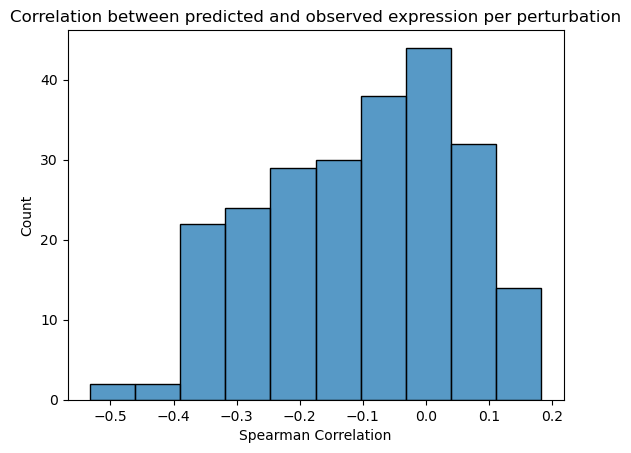

In [8]:
# plot train correlation distribution vs test correlation distribution
import seaborn as sns

test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [91]:
np.savetxt(
    "figures/reconstruction_spearmans/GSFA_norman_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform

# Put into df
pert_emb_df = pd.DataFrame(beta[:-1], index=pert_labels)
pert_emb_df = pert_emb_df.drop(columns=[0]).astype("float")

# Compute the pairwise distances
df = pert_emb_df.drop(index=["ctrl"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)

# Compute the linkage matrix using the condensed distance matrix
linkage_matrix = linkage(distance_matrix, method="ward")

# Plot the dendrogram (optional)
dendro = dendrogram(linkage_matrix, no_plot=True)

# Assign clusters
max_d = 10  # Max distance for flat clusters
clusters = fcluster(linkage_matrix, max_d, criterion="distance")

# Create a color palette for clusters
palette = sns.color_palette("husl", len(np.unique(clusters)))

# Map each cluster id to a color
cluster_colors = [palette[i - 1] for i in clusters]

# Show the plot
plt.show()

clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=cluster_colors
)
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
# clustermap.cax.set_visible(False)
plt.show()

In [10]:
# extract clusters and perform gprofiler
index_names = list(distance_matrix.index)
cluster_df = pd.DataFrame({"Pert": index_names, "Cluster": clusters})
cluster_process = {}
for cluster_id in np.unique(clusters):
    points_in_cluster = cluster_df[cluster_df["Cluster"] == cluster_id]["Pert"].tolist()
    gprofiler_in = pd.DataFrame(points_in_cluster, columns=["gene_symbol"])
    res = get_gprofiler(gprofiler_in)
    cluster_process[cluster_id] = res[res["p_value"] <= 0.05]

In [ ]:
# Create descriptions for each cluster (for demonstration purpose)
cluster_descriptions = {
    1: "",
    2: "Embryonic development",
    3: "Transcription cis-regulatory region binding, metabolic process",
    4: "protein serine/threonine kinase activity",
    5: "",
    6: "DNA-binding transcription factor activity, RNA polymerase II transcription regulatory region",
    7: "",
    8: "DNA binding, negative regulation of biosynthetic process",
    9: "",
    10: "chromatin",
    11: "epidermal growth factor",
    12: "collagen type II trimer",
    13: "",
    14: "",
    15: "C/EBP complex",
    16: "",
}

# Create a consistent color palette
unique_clusters = sorted(np.unique(clusters))
palette = sns.color_palette("husl", len(unique_clusters))
cluster_colors = [palette[i - 1] for i in clusters]
cluster_colors = {cid: palette[i] for i, cid in enumerate(unique_clusters)}

# Create clustermap using consistent colors
row_colors = [cluster_colors[cid] for cid in clusters]
clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=[palette[i - 1] for i in clusters]
)
clustermap.savefig(
    "figures/figure_pngs/GSFA_norman_clustermap.png", dpi=600, bbox_inches="tight"
)

# Prepare data for the table
cluster_data = {
    "Cluster ID": unique_clusters,
    "Description": [cluster_descriptions[cid] for cid in unique_clusters],
}

cluster_df = pd.DataFrame(cluster_data)

# Plot the table with colors matching the clustermap
fig, ax = plt.subplots(figsize=(18, 4))
ax.axis("off")
ax.axis("tight")

# Create table while applying the color to the row background
table = ax.table(
    cellText=cluster_df.values,
    colLabels=["Cluster ID", "Description"],
    cellColours=[[cluster_colors[cid]] * 2 for cid in cluster_df["Cluster ID"]],
    cellLoc="center",
    loc="center",
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig(
    "figures/figure_pngs/GSFA_norman_clustermap_descriptions.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

In [250]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/GSFA_norman_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [237]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/GSFA_norman_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/GSFA_norman_f1.csv")

               AUC
StringDB  0.732776
CORUM     0.946837
                F1  Threshold
StringDB  0.820312        1.0
CORUM     0.972222        1.0


# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, W.T, fdr=5e-2)

In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [105]:
with open(
    "figures/factor_enrichments/GSFA_norman_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Overlap with prior knowledge/ground truth (stringdb)
- Group A: a set of GO terms associated with a perturbation (either drivers from msigdb, or from literature) and its neighbors in stringdb
- Group B: a set of GO terms from the interpretability analysis
- Hypergeometric test on the overlap of the two groups

In [4]:
# load precomputed factor_to_go dict if available
filtered_factor_to_go = read_aws_pickle(
    "s3://pert-spectra/figures/factor_enrichments/GSFA_norman_factor_enrichment.pickle"
)

In [5]:
# get neighbors for each perturbation
pert_neighbors = retrieve_stringdb_neighbors(pert_labels)

In [8]:
# construct group A - known processes for each perturbation
gene_sets = read_aws_pickle("s3://pert-spectra/references/GO_to_Gene.pickle")
# BP only go terms
go_reference = read_aws_csv("s3://pert-spectra/references/GO_terms.txt.gz", zipped=True)
go_bp = go_reference[go_reference["go_category"] == "biological_process"]
go_bp_ids = set(go_bp["go_id"].values)
filtered_go_terms = {key: gene_sets[key] for key in go_bp_ids if key in gene_sets}

# GO terms per perturbation AND its neighbors in stringdb
pert_to_go = {key: set() for key in df.index}
for goterm in filtered_go_terms:
    for pert in df.index:
        if pert in filtered_go_terms[goterm] and set(
            filtered_go_terms[goterm]
        ).intersection(pert_neighbors[pert]):
            pert_to_go[pert].add(goterm)

In [9]:
# construct set B - model identified processes for each perturbation
n = 10  # number of top factors to get processes from
model_pert_to_go = {}
for pert in pert_emb_df.index:
    if pert in ["ctrl", "intergenic", "basal"]:
        continue
    # get top factors
    pert_emb_df = pd.DataFrame(beta[:-1], index=pert_labels)
    pert_loading = pert_emb_df.loc[pert].to_numpy()[1:].astype(float)
    ctrl_loading = pert_emb_df.loc["ctrl"].to_numpy()[1:].astype(float)
    delta_loading = np.abs(np.log(np.abs(pert_loading)) - np.log(np.abs(ctrl_loading)))
    top_n_factors = np.argpartition(np.array(delta_loading), -n)[-n:]
    # get processes
    model_processes = set()
    for f in top_n_factors:
        proc = filtered_factor_to_go[f]
        model_processes = model_processes.union(set(proc["Term"]))
    model_pert_to_go[pert] = model_processes

In [10]:
pvals = perturbation_signal_recovery(
    pert_to_go,
    model_pert_to_go,
    list(filtered_go_terms.keys()),
    list(pert_emb_df.index),
)

Overlap for AHR: 5 out of 12 in researchDB
P-value for AHR: 2.1319858454369287e-07
Overlap for ARID1A: 5 out of 16 in researchDB
P-value for ARID1A: 2.2083684093482343e-06
Overlap for BAK1: 5 out of 43 in researchDB
P-value for BAK1: 0.00046615592180678417
Overlap for BCL2L11: 3 out of 29 in researchDB
P-value for BCL2L11: 0.008310750164771933
Overlap for CBL: 5 out of 28 in researchDB
P-value for CBL: 0.00014285653454198518
Overlap for CDKN1A: 3 out of 37 in researchDB
P-value for CDKN1A: 0.0090102759706699
Overlap for CDKN1B: 2 out of 38 in researchDB
P-value for CDKN1B: 0.08621078058192475
Overlap for CDKN1C: 3 out of 15 in researchDB
P-value for CDKN1C: 0.0008590529302742615
Overlap for CEBPA: 10 out of 34 in researchDB
P-value for CEBPA: 9.605689713987963e-11
Overlap for CEBPB: 8 out of 33 in researchDB
P-value for CEBPB: 3.5589724354327065e-08
Overlap for CEBPE: 5 out of 9 in researchDB
P-value for CEBPE: 9.287161274422125e-08
Overlap for CITED1: 6 out of 14 in researchDB
P-value

In [12]:
# save as csv for visualization
pd.DataFrame.from_dict(data=pvals, orient="index").to_csv(
    "figures/process_recovery_hypergeo_pvals/GSFA_norman_hypergeo_neighbors_recovery_pvalues.csv",
    header=False,
)